# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
import scippneutron as scn
from scippneutron.conversion import graph
import os
from IPython.display import Image
import h5py
import sys
from TubeMeasurment import tube_measurement


## Data reduction process

Full overview of how converison is done: 

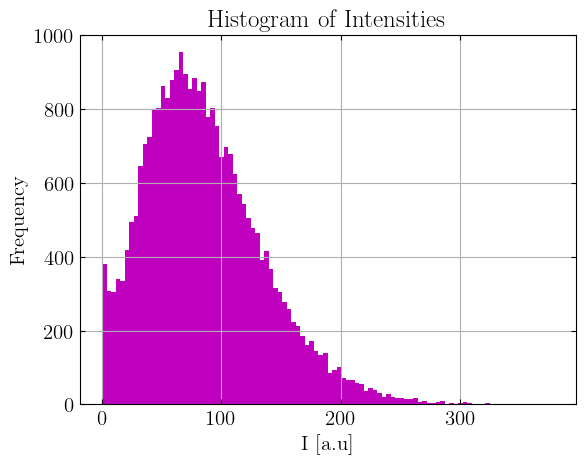

In [2]:
scan_file_path = '../McStasScript/run_folder/res_sample_test1/mccode.h5'

ob = tube_measurement(wedge=6, arc=4, tube=1)
ob.getI(scan_file_path)
ob.getI_err(scan_file_path)

ob.get_t_s(scan_file_path)
ob.get_y_m(scan_file_path)
ob.getA3(scan_file_path)

ob.getA4(scan_file_path)

ob.calcDE()
ob.calcQ()

#print(ob.CorrectI())

ob.flatten()

data_flat = ob.I

plt.hist(data_flat[(data_flat>0.01)], bins=100, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()


[0. 0. 0. ... 0. 0. 0.]


Text(0, 0.5, 'DeltaE')

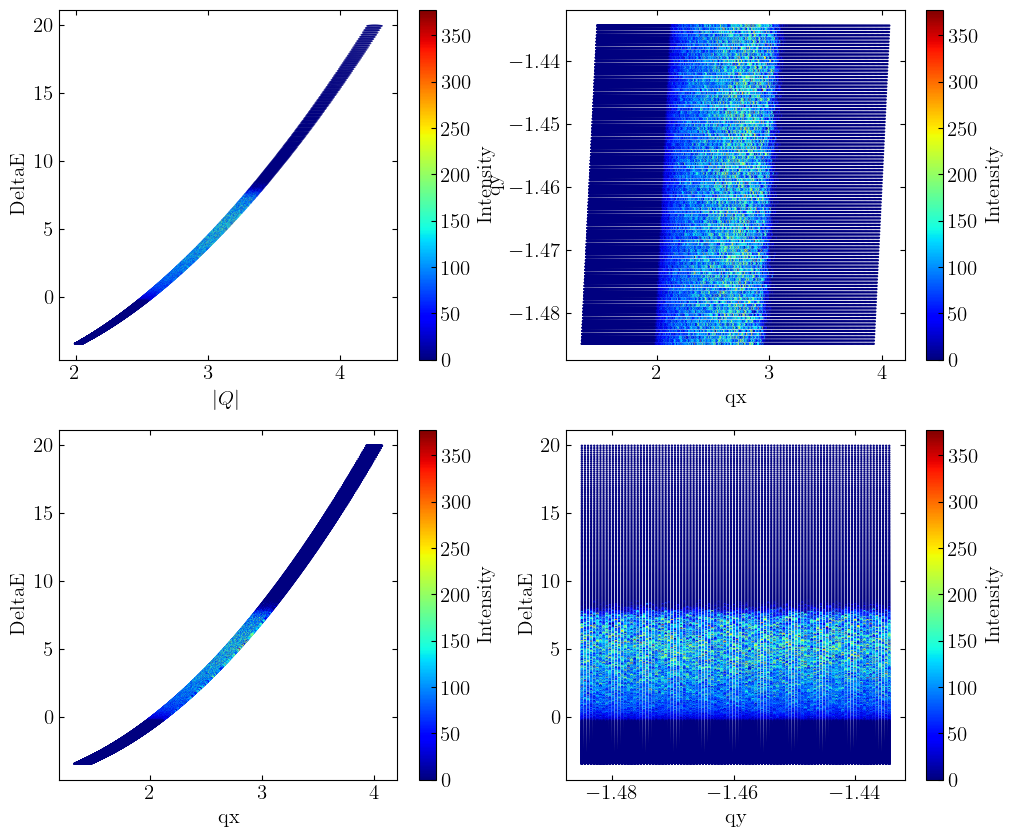

In [3]:
deltaE1 = ob.Delta_E
I1 = ob.I
I1_err = ob.I_err
Q = np.sqrt(ob.Q[0]**2+ob.Q[1]**2)
qx1 = ob.Q[0]
qy1 = ob.Q[1]

I1 = I1[deltaE1<20]
I1_err = I1_err[deltaE1<20]
Q = Q[deltaE1<20]
qy1 = qy1[deltaE1<20]
qx1 = qx1[deltaE1<20]
deltaE1 = deltaE1[deltaE1<20]
print(ob.I)



fig, ax = plt.subplots(2,2, figsize=(12,10))
sc1 = ax[0,0].scatter(Q, deltaE1, c=I1, cmap='jet', s=0.01)
plt.colorbar(sc1, ax=ax[0,0],label='Intensity')
ax[0,0].set_xlabel(r'$|Q|$')
ax[0,0].set_ylabel('DeltaE')

sc2 = ax[0,1].scatter(qx1, qy1, c=I1, cmap='jet', s=0.5)
plt.colorbar(sc2, ax=ax[0,1],label='Intensity')
ax[0,1].set_xlabel('qx')
ax[0,1].set_ylabel('qy')

sc3 = ax[1,0].scatter(qx1, deltaE1, c=I1, cmap='jet', s=0.5)
plt.colorbar(sc3, ax=ax[1,0],label='Intensity')
ax[1,0].set_xlabel('qx')
ax[1,0].set_ylabel('DeltaE')

sc4 = ax[1,1].scatter(qy1, deltaE1, c=I1, cmap='jet', s=0.5)
plt.colorbar(sc4, ax=ax[1,1],label='Intensity')
ax[1,1].set_xlabel('qy')
ax[1,1].set_ylabel('DeltaE')

# Scipp binning of one instrument setting

In [4]:

qx = sc.array(dims=["row"], values=qx1, unit="Å^(-1)")
qy = sc.array(dims=["row"], values=qy1, unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=deltaE1, unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(qx1**2+qy1**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=I1, unit="Å^(-1)", variances=I1_err), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=100, qy=100, deltaE=50)
slicedQ = recording.bin(deltaE=50, Q=100)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ


<scipp.DataArray>
Dimensions: Sizes[deltaE:50, Q:100, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [1.99287, 2.01608, ..., 4.29062, 4.31383]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-3.45308, -2.98558, ..., 19.4543, 19.9218]
Data:
                            float64           [1/Å]  (deltaE, Q)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

/Users/kristinekrighaar/opt/anaconda3/lib/python3.9/site-packages/scipp/core/deprecation.py:7: VisibleDeprecationWarning: sc.DataArray.attrs has been deprecated and will be removed in Scipp v24.12.0. The deprecation includes sc.DataArray.meta and sc.DataArray.drop_attrs. For unaligned coords, use sc.DataArray.coords and unset the alignment flag. For other attributes, use a higher-level data structure.
  warnings.warn(


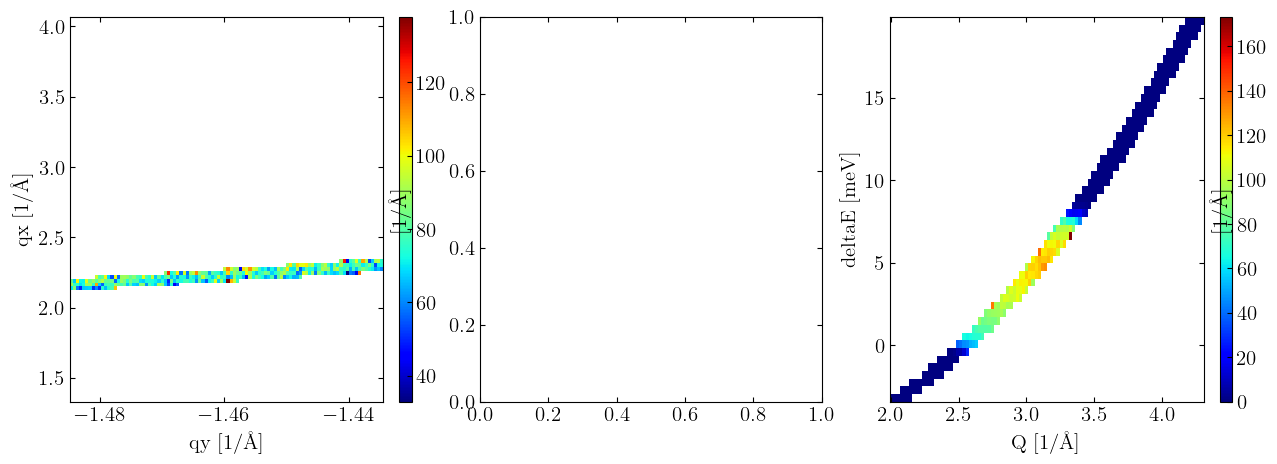

In [5]:
E_layer = 1 * sc.Unit('meV')
qy_layer = -1.53 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
p1 = sliced['deltaE', E_layer].plot( ax=ax[0], cmap='jet')
#p2 = sliced['qy', qy_layer].plot(ax=ax[1], cmap='jet')
p3 = slicedQ.plot(ax=ax[2], cmap='jet')


## Importing all tubes for a given A3, A4 setting.

In [6]:

def load_Backend_measurment(filepath):
    """
    
    """
    setting = {}
    
    I = []
    I_err = []
    DeltaE = []
    qx = []
    qy = []

    for w in range(9):
        for t in range(3):
            obj = tube_measurement(wedge=w, arc=4, tube=t)

            obj.getI(filepath)
            obj.getI_err(filepath)

            obj.get_t_s(filepath)
            obj.get_y_m(filepath)
            obj.getA4(filepath)

            obj.getA3(filepath)
            obj.calcDE()
            obj.calcQ()
            #obj.CorrectI()
            obj.flatten()

            I.append(obj.I)
            I_err.append(obj.I_err)
            DeltaE.append(obj.Delta_E)
            qx.append(obj.Q[0])
            qy.append(obj.Q[1])

            setting['TM_'+str(w)+'_4_'+str(t)] = obj

    I = np.asarray(I).flatten()
    I_err = np.asarray(I_err).flatten()
    DeltaE = np.asarray(DeltaE).flatten()
    qx = np.asarray(qx).flatten()
    qy = np.asarray(qy).flatten()

    return I, I_err, DeltaE, qx, qy


settings = load_Backend_measurment('../McStasScript/run_folder/res_sample_test1/mccode.h5')

print('Estimated memory size of a Backend measurment =',sys.getsizeof(settings)/1024, 'kB')

print(len(settings[0]))
print(len(settings[1]))
print(len(settings[2]))
print(len(settings[3]))
print(len(settings[4]))

Estimated memory size of a Backend measurment = 0.078125 kB
2700000
2700000
2700000
2700000
2700000


## Exporting dataformat for MJOLNIR

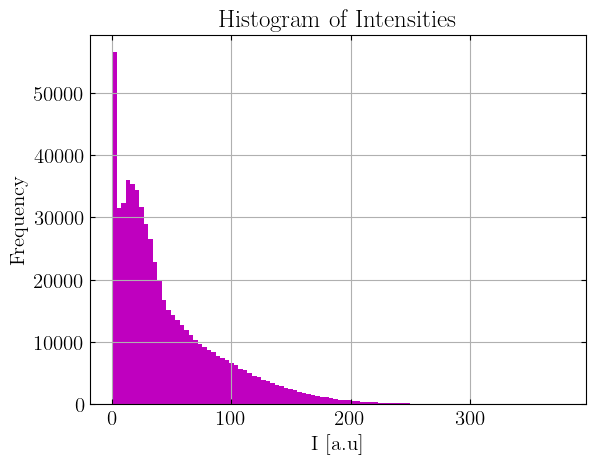

In [7]:
data_flat = settings[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.01)], bins=100, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

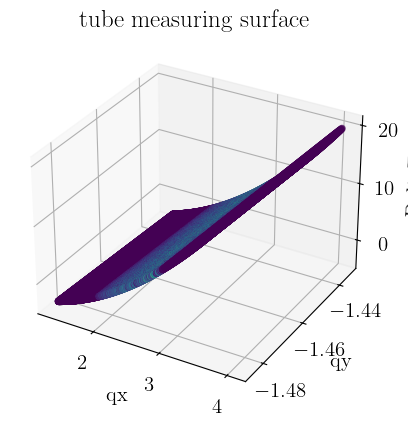

In [8]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data
ax.scatter(qx1, qy1, deltaE1, c=I1)

ax.set_xlabel('qx')
ax.set_ylabel('qy')
ax.set_zlabel('DeltaE')
ax.set_title('tube measuring surface')
plt.show()

In [9]:


qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="Å^(-1)", variances=settings[1]), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=200, qy=200, deltaE=100)
slicedQ = recording.bin(deltaE=200, Q=100)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:200, Q:100, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [1.14251, 1.19775, ..., 6.6115, 6.66674]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-3.45308, -3.14559, ..., 57.7364, 58.0439]
Data:
                            float64           [1/Å]  (deltaE, Q)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

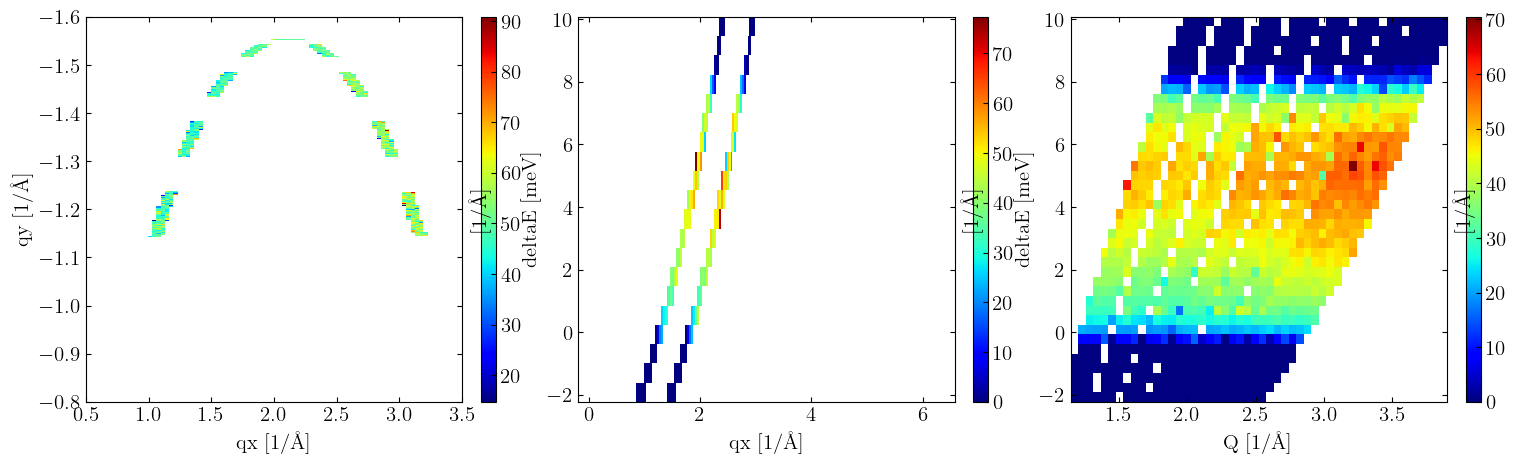

In [10]:
E_layer = 4.0 * sc.Unit('meV')
qy_layer = -1.53 * sc.Unit('Å^(-1)')

E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

qx_min = 0 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

qy_min = -2.0 * sc.Unit('Å^(-1)')
qy_max = 0 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose().plot(ax=ax[0], cmap='jet')
ax[0].set_xlim(0.5,3.5)
ax[0].set_ylim(-0.8,-1.6)
p2 = sliced['deltaE', E_min:E_max]['qy', qy_layer].transpose().plot(ax=ax[1], cmap='jet')
p3 = slicedQ['deltaE', E_min:E_max]['Q', 0:50].plot(ax=ax[2], cmap='jet')